In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import concurrent.futures

In [3]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [4]:
mask_path = '../data'
frames_path = '../data/frames/C59_L1_t0'
output_path = '../data/auto_seg'

In [5]:
frame_count = 1100

angle_increment = 2
min_angle = 10
max_angle = 80

blur_amount = 7

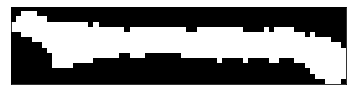

In [6]:
img_mask = cv2.imread(os.path.join(mask_path,'mask-1-cropped.jpg'),0)
ret, img_mask = cv2.threshold(img_mask, 10, 255, cv2.THRESH_BINARY)

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(img_mask,'gray')
plt.show()

In [7]:
def find_mask(frame_no):
    # Get file name
    file_name = "frame-%d.jpg" % frame_no
    
    # Open image and pre-process
    img_orig = cv2.imread(os.path.join(frames_path,file_name),0)
    img_blur = cv2.medianBlur(img_orig,blur_amount)
    img_thresh = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    img_thresh_inv = cv2.bitwise_not(img_thresh)
    
    # Init variables
    angle = min_angle
    images = []
    scores = []
    positions = []
    
    # Log 
    rows,cols = img_orig.shape
    #print("Frame {0} has {1} rows and {2} cols".format(i,rows,cols))
    
    while angle <= max_angle:
    
        # Rotate mask and log
        img_mask_rotated = rotate_bound(img_mask, angle)
        ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
        mask_rows,mask_cols = img_mask_rotated.shape
        #print("Current rotation {2} degrees has {0} rows and {1} cols".format(mask_rows,mask_cols,angle))
    
        # Pass image over
        for i in range(rows):
            if i + mask_rows > rows:
                continue
            for j in range(cols):
                if j + mask_cols > cols:
                    continue
            
                # Create roi
                roi = img_thresh_inv[i:mask_rows+i,j:mask_cols+j]

                # Mask with mask
                masked = cv2.bitwise_and(roi,img_mask_rotated)
            
                # Save image and scores
                images.append(masked)
                scores.append(masked.sum())
                positions.append([i,j,angle])
            
        angle += angle_increment
    
    max_score = np.max(scores)
    max_index = np.argmax(scores)
    best_position = positions[max_index]
    
    # Reload the best mask
    img_mask_rotated = rotate_bound(img_mask, best_position[2])
    ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
    mask_rows,mask_cols = img_mask_rotated.shape
    
    # Output mask  
    final_mask = np.zeros(img_orig.shape)
    final_mask[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]] = img_mask_rotated
    
    # Create final roi
    roi1 = img_orig[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]]
    masked_orig = cv2.bitwise_and(roi1,img_mask_rotated)
    
    # Create large image
    final_mask_orig = np.zeros(img_orig.shape)
    final_mask_orig[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]] = masked_orig
    
    # Save mask and frame to file
    frame_name = "frame-%d.png" % frame_no
    mask_name = "mask-%d.png" % frame_no
    crop_name = "crop-%d.png" % frame_no
    real_name = "real-%d.png" % frame_no
    
    cv2.imwrite(os.path.join(output_path,"frames",frame_name), img_orig)
    cv2.imwrite(os.path.join(output_path,"masks",mask_name), final_mask)
    cv2.imwrite(os.path.join(output_path,"crops",crop_name), masked_orig) 
    cv2.imwrite(os.path.join(output_path,"real_masks",real_name), final_mask_orig) 
    
    #print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(frame_no,max_score,best_position[0],best_position[1],best_position[2]))    
    return [frame_no,max_score,best_position[0],best_position[1],best_position[2]]

In [9]:
#for frame_no in range(frame_count):
#    result = find_mask(frame_no)
#    print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(result[0],result[1],result[2],result[3],result[4]))
#    break

In [10]:
# run mult-threaded
results = []
frame_range = range(frame_count)
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = [executor.submit(find_mask, frame_no) for frame_no in frame_range]
    
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        results.append(result)
        print("Frame {0}: MS={1} BP-X:{2} BP-Y:{3} BP-A:{4}".format(result[0],result[1],result[2],result[3],result[4]))

Frame 0: MS=102000 BP-X:18 BP-Y:38 BP-A:38
Frame 4: MS=92310 BP-X:19 BP-Y:39 BP-A:38
Frame 2: MS=96645 BP-X:19 BP-Y:39 BP-A:38
Frame 1: MS=98175 BP-X:18 BP-Y:38 BP-A:38
Frame 5: MS=96135 BP-X:18 BP-Y:38 BP-A:38
Frame 6: MS=95625 BP-X:19 BP-Y:40 BP-A:38
Frame 7: MS=94605 BP-X:18 BP-Y:38 BP-A:38
Frame 3: MS=97920 BP-X:19 BP-Y:39 BP-A:38
Frame 8: MS=99705 BP-X:19 BP-Y:39 BP-A:38
Frame 9: MS=100215 BP-X:19 BP-Y:39 BP-A:38
Frame 11: MS=99450 BP-X:19 BP-Y:39 BP-A:38
Frame 10: MS=96900 BP-X:18 BP-Y:38 BP-A:38
Frame 12: MS=97665 BP-X:18 BP-Y:38 BP-A:38
Frame 13: MS=97410 BP-X:18 BP-Y:38 BP-A:38
Frame 15: MS=97155 BP-X:19 BP-Y:39 BP-A:38
Frame 14: MS=96900 BP-X:18 BP-Y:39 BP-A:38
Frame 16: MS=98175 BP-X:18 BP-Y:39 BP-A:38
Frame 17: MS=98430 BP-X:18 BP-Y:39 BP-A:38
Frame 18: MS=101235 BP-X:19 BP-Y:39 BP-A:38
Frame 21: MS=98685 BP-X:18 BP-Y:38 BP-A:38
Frame 19: MS=91290 BP-X:18 BP-Y:40 BP-A:40
Frame 23: MS=96645 BP-X:19 BP-Y:39 BP-A:38
Frame 20: MS=93075 BP-X:18 BP-Y:38 BP-A:38
Frame 22: MS=10021

In [17]:
#print(results)
np.savetxt(os.path.join(output_path,"summary.csv"),results, header="frame_no,score,xpos,ypos,angle",delimiter=",")